# Kobe Bryant Shot Selection
#### Which shots did Kobe Sink?

#### In memory of **Kobe Bean Bryant** and **Gianna Bryant**
<img src="media/kobexgigi.jpg" style="width:552px;height:331px"/>

This is the first out of two notebooks composing a Machine Learning project for a Kaggle competition about one of the greatest basketball players in history, Kobe Bryant, the dataset includes every single shot he made in the NBA (does not include Free Throws and shots taken with the U.S National Team).
The purpose of the competition is training a Machine Learning model to predict the probability of a shot going in the basket based on features such as distance, time remaining and many features which we'll be exploring.

#### Importing libraries

In [1]:
import numpy as np
import pandas as pd
import pandasql as ps
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Rectangle, Arc
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

Adjusting some pandas settings that are irrelevant to the project but allowed my workflow to be more efficient

In [2]:
pd.options.display.max_columns = 100
pd.options.display.max_colwidth = None

#### Loading the data
After reading the specifications for each column on the competition's page we realized that we do not need:
- game_id: game_date is also a unique identifier for each game and provides more useful information
- game_event_id: identifier for each action in a specific game.
- team_id and team_name: unique id for the team in which Kobe played, since he only played for the Lakers in the NBA and this dataset doesn't include shots taken with the US National team all the values are the same.

The only id we'll keep is the shot_id since our submission requires our predictions to be attached to it's shot_id

Not using them will reduce the memory footprint.

In [3]:
kb = pd.read_csv('kobe_shots.csv', parse_dates=['game_date']).drop(columns=['game_id', 'game_event_id', 'team_id', 'team_name'])

In [4]:
print(kb.shape)
kb.head()

(30697, 21)


,action_type,combined_shot_type,lat,loc_x,loc_y,lon,minutes_remaining,period,playoffs,season,seconds_remaining,shot_distance,shot_made_flag,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,game_date,matchup,opponent,shot_id
0,Jump Shot,Jump Shot,33.9723,167,72,-118.1028,10,1,0,2000-01,27,18,NaN,2PT Field Goal,Right Side(R),Mid-Range,16-24 ft.,2000-10-31,LAL @ POR,POR,1
1,Jump Shot,Jump Shot,34.0443,-157,0,-118.4268,10,1,0,2000-01,22,15,0.0,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,2000-10-31,LAL @ POR,POR,2
2,Jump Shot,Jump Shot,33.9093,-101,135,-118.3708,7,1,0,2000-01,45,16,1.0,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,2000-10-31,LAL @ POR,POR,3
3,Jump Shot,Jump Shot,33.8693,138,175,-118.1318,6,1,0,2000-01,52,22,0.0,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,2000-10-31,LAL @ POR,POR,4
4,Driving Dunk Shot,Dunk,34.0443,0,0,-118.2698,6,2,0,2000-01,19,0,1.0,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,2000-10-31,LAL @ POR,POR,5


The dataset we're working with contains 25 columns and 30679 rows, that means 30679 shots and 25 attributes corresponding to each shot.

Let's check if there are any missing values.

In [5]:
kb.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30697 entries, 0 to 30696
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   action_type         30697 non-null  object        
 1   combined_shot_type  30697 non-null  object        
 2   lat                 30697 non-null  float64       
 3   loc_x               30697 non-null  int64         
 4   loc_y               30697 non-null  int64         
 5   lon                 30697 non-null  float64       
 6   minutes_remaining   30697 non-null  int64         
 7   period              30697 non-null  int64         
 8   playoffs            30697 non-null  int64         
 9   season              30697 non-null  object        
 10  seconds_remaining   30697 non-null  int64         
 11  shot_distance       30697 non-null  int64         
 12  shot_made_flag      25697 non-null  float64       
 13  shot_type           30697 non-null  object    

<AxesSubplot:>

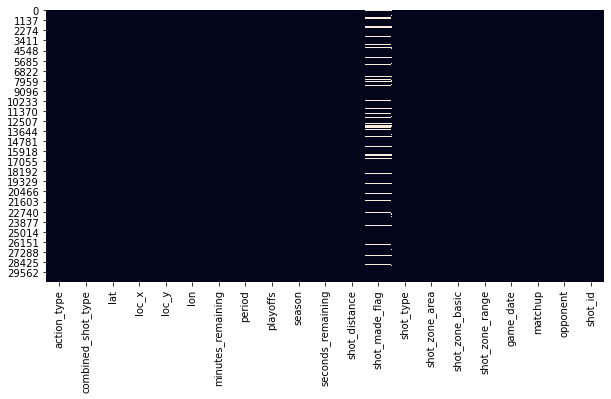

In [6]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.heatmap(kb.isnull(), cbar=False)

We can se that the only column with null values is the shot_made_flag and it has exactly 5000 missing values which were intentionally removed so that participants will make predictions on it and get a score based on the predictions submitted.

### Sorting

Because we can only predict using shots made before the shot being predicted, we should sort them by chronological order.

First we'll order by date (ascending), then period in which the shot was taken (ascending), minutes remaining (descending) and seconds remaing (descending) by using PandaSQL.

In [7]:
kb = ps.sqldf('''
select *
from kb
order by 
    game_date asc, 
    period asc, 
    minutes_remaining desc, 
    seconds_remaining desc''')
kb.head()

,action_type,combined_shot_type,lat,loc_x,loc_y,lon,minutes_remaining,period,playoffs,season,seconds_remaining,shot_distance,shot_made_flag,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,game_date,matchup,opponent,shot_id
0,Jump Shot,Jump Shot,33.9283,-140,116,-118.4098,0,1,0,1996-97,42,18,0.0,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1996-11-03 00:00:00.000000,LAL vs. MIN,MIN,22902
1,Jump Shot,Jump Shot,33.9473,-131,97,-118.4008,10,2,0,1996-97,8,16,0.0,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1996-11-05 00:00:00.000000,LAL @ NYK,NYK,22903
2,Jump Shot,Jump Shot,33.8633,-142,181,-118.4118,8,2,0,1996-97,37,23,1.0,3PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1996-11-06 00:00:00.000000,LAL @ CHH,CHA,22904
3,Jump Shot,Jump Shot,34.0443,0,0,-118.2698,6,2,0,1996-97,34,0,0.0,3PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1996-11-06 00:00:00.000000,LAL @ CHH,CHA,22905
4,Jump Shot,Jump Shot,33.9063,-10,138,-118.2798,5,2,0,1996-97,27,13,1.0,2PT Field Goal,Center(C),In The Paint (Non-RA),8-16 ft.,1996-11-06 00:00:00.000000,LAL @ CHH,CHA,22906


The date of the game itself isn't a great feature but the month in which the game was played might be useful by helping the model find patterns related to the stage of the season in which the game took place.

In [8]:
kb['month'] = kb['game_date'].str[5:7]

In order to make it a numeric feature we will replace it for sequential numbering from the first month of the season, labeled as 0.

In [9]:
kb['month'].replace(kb['month'].unique(), np.arange(len(kb['month'].unique())), inplace=True)

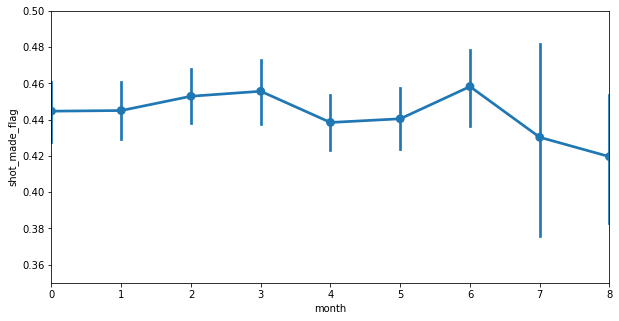

In [10]:
plt.figure(figsize=(10, 5))
sns.pointplot(x='month', y='shot_made_flag', data=kb)
plt.xlim(0, 8)
plt.ylim(0.35, 0.5)
plt.show()

#### Time remaining
The minutes_remaining and seconds_remaining are relative to the end of the quarter and not the whole match, let's combine them into a single feature named time_remaining.

In [11]:
#creating the time_remaining feature
kb['time_remaining'] = (kb['minutes_remaining']*60) + kb['seconds_remaining']
    
#dropping the minutes_remaining and seconds_remaining columns
kb.drop(columns=['minutes_remaining', 'seconds_remaining'], inplace=True)

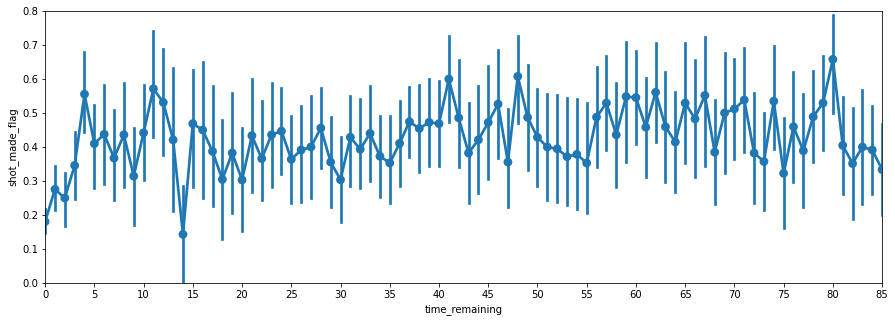

In [12]:
plt.figure(figsize=(15, 5))
sns.pointplot(x='time_remaining', y='shot_made_flag', data=kb)
plt.xlim(0, 60)
plt.ylim(0, 0.8)
plt.xticks(np.arange(0, 90, 5), np.arange(0, 90, 5))
plt.show()

Because the time_remaining feature is too noisy we'll drop it.

#### Position

2 different pairs of our features represent the exact position in the court from which the shot was taken
- loc_x & loc_y

- lon & lat

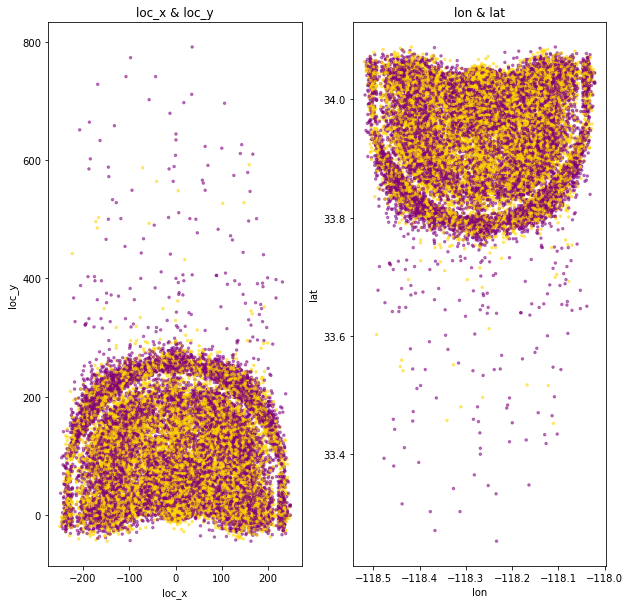

In [13]:
plt.figure(figsize=(10, 10))

colors = np.where(kb['shot_made_flag']==0, 'Purple', 'Gold')
colors.shape

plt.subplot(121)
plt.title('loc_x & loc_y')
plt.xlabel('loc_x')
plt.ylabel('loc_y')
plt.scatter(kb['loc_x'], kb['loc_y'], color=colors, s=6, alpha=0.5)

plt.subplot(122)
plt.title('lon & lat')
plt.xlabel('lon')
plt.ylabel('lat')
plt.scatter(kb['lon'], kb['lat'], color=colors, s=6, alpha=0.5)

As seen in the plot above they closely resemble a basketball court and the 3-point area.

After doing some research and seeing notebooks from other users who participated on the competition or just uploaded their project on github I found someone who shared the function below. It 
helps us draw a Court and plot the shots inside of it.
Thanks to Avinash PanigrahiAvinash Panigrahi.

You can find his notebook on the same project here: https://github.com/avirichie/Kobe-Bryant-Shot-Selection/blob/master/Dear_Kobe.ipynbhttps://github.com/avirichie/Kobe-Bryant-Shot-Selection/blob/master/Dear_Kobe.ipynb

Also because they represent the same, we'll just work with loc_x and loc_y

In [14]:
def draw_court(ax=None, color='black', lw=1.5, outer_lines=False):
    # If an axes object isn't provided to plot onto, just get current one
    if ax is None:
        ax = plt.gca()

    # Create the various parts of an NBA basketball court

    # Create the basketball hoop
    # Diameter of a hoop is 18" so it has a radius of 9", which is a value
    # 7.5 in our coordinate system
    hoop = Circle((0, 0), radius=7.5, linewidth=lw, color=color, fill=False)

    # Create backboard
    backboard = Rectangle((-30, -7.5), 60, -1, linewidth=lw, color=color)

    # The paint
    # Create the outer box 0f the paint, width=16ft, height=19ft
    outer_box = Rectangle((-80, -47.5), 160, 190, linewidth=lw, color=color,
                          fill=False)
    # Create the inner box of the paint, widt=12ft, height=19ft
    inner_box = Rectangle((-60, -47.5), 120, 190, linewidth=lw, color=color,
                          fill=False)

    # Create free throw top arc
    top_free_throw = Arc((0, 142.5), 120, 120, theta1=0, theta2=180,
                         linewidth=lw, color=color, fill=False)
    # Create free throw bottom arc
    bottom_free_throw = Arc((0, 142.5), 120, 120, theta1=180, theta2=0,
                            linewidth=lw, color=color, linestyle='dashed')
    # Restricted Zone, it is an arc with 4ft radius from center of the hoop
    restricted = Arc((0, 0), 80, 80, theta1=0, theta2=180, linewidth=lw,
                     color=color)

    # Three point line
    # Create the side 3pt lines, they are 14ft long before they begin to arc
    corner_three_a = Rectangle((-220, -47.5), 0, 140, linewidth=lw,
                               color=color)
    corner_three_b = Rectangle((220, -47.5), 0, 140, linewidth=lw, color=color)
    # 3pt arc - center of arc will be the hoop, arc is 23'9" away from hoop
    # I just played around with the theta values until they lined up with the 
    # threes
    three_arc = Arc((0, 0), 475, 475, theta1=22, theta2=158, linewidth=lw,
                    color=color)

    # Center Court
    center_outer_arc = Arc((0, 422.5), 120, 120, theta1=180, theta2=0,
                           linewidth=lw, color=color)
    center_inner_arc = Arc((0, 422.5), 40, 40, theta1=180, theta2=0,
                           linewidth=lw, color=color)

    # List of the court elements to be plotted onto the axes
    court_elements = [hoop, backboard, outer_box, inner_box, top_free_throw,
                      bottom_free_throw, restricted, corner_three_a,
                      corner_three_b, three_arc, center_outer_arc,
                      center_inner_arc]

    if outer_lines:
        # Draw the half court line, baseline and side out bound lines
        outer_lines = Rectangle((-250, -47.5), 500, 470, linewidth=lw,
                                color=color, fill=False)
        court_elements.append(outer_lines)

    # Add the court elements onto the axes
    for element in court_elements:
        ax.add_patch(element)

    return ax

Text(0.5, 1.0, 'shot attempts')

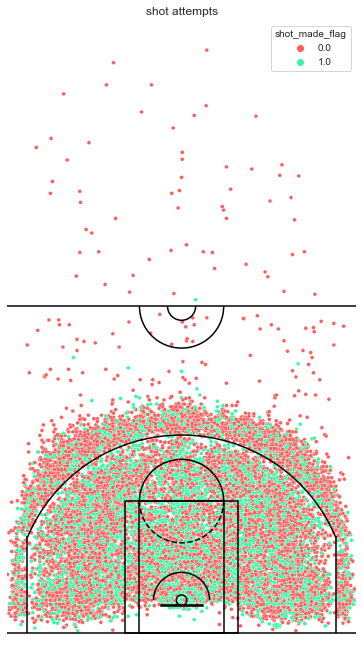

In [15]:
sns.set_style(style='white')
fig, ax = plt.subplots(figsize=(6.25, 11.75))
h_order=[1,0]
g = sns.scatterplot(data=kb, x='loc_x', y='loc_y', hue='shot_made_flag', s=15, palette={1:'#33faa4', 0:'#fd5d5d'})
sns.despine(fig=None, ax=None, top=True, right=True, left=True, bottom=True, offset=None, trim=True)
g.set(yticks=[], xticks=[])
ax.set_xlim(-248.5, 248.5)
ax.set_ylabel('')    
ax.set_xlabel('')
draw_court(outer_lines=True); plt.title('shot attempts')
#fig.savefig('kobe_shot_attempts.png')

The plot above gives us an idea of how many shots Kobe took and wether they went in or out. Still this doesn't give us a clear idea on how to determine if a shot goes in or out.

Let's see, out of the shots we know the outcome, the distance of longest shot he scored.

In [16]:
longest_shot_made = kb.loc[kb['shot_made_flag'] ==1, ['shot_distance']].max()[0]
longest_shot_made

43

Out of the data we have available, the longest shot Kobe made was from 43 feet or 13.11 meters, he actually took 4 more shots from a similar distance.

In [17]:
kb.loc[(kb['shot_distance']==longest_shot_made) & kb['shot_made_flag'] == 1]

,action_type,combined_shot_type,lat,loc_x,loc_y,lon,period,playoffs,season,shot_distance,shot_made_flag,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,game_date,matchup,opponent,shot_id,month,time_remaining
7018,Jump Shot,Jump Shot,33.6123,20,432,-118.2498,2,0,2001-02,43,1.0,3PT Field Goal,Back Court(BC),Backcourt,Back Court Shot,2002-03-06 00:00:00.000000,LAL @ UTA,UTA,2697,4,0


Text(0.5, 1.0, 'shot attempts')

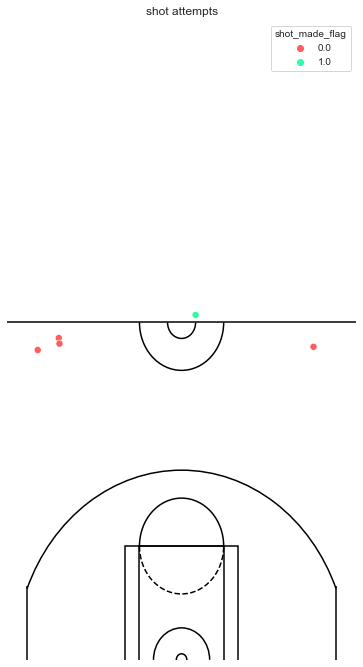

In [18]:
sns.set_style(style='white')
fig, ax = plt.subplots(figsize=(6.25, 11.75))
h_order=[1,0]
g = sns.scatterplot(data=kb.loc[kb['shot_distance']==longest_shot_made,:], x='loc_x', y='loc_y', hue='shot_made_flag', s=50, palette={1:'#33faa4', 0:'#fd5d5d'})
sns.despine(fig=None, ax=None, top=True, right=True, left=True, bottom=True, offset=None, trim=True)
g.set(yticks=[], xticks=[])
ax.set_ylim(0, 800)
ax.set_xlim(-248.5, 248.5)
ax.set_ylabel('')    
ax.set_xlabel('')
draw_court(outer_lines=True); plt.title('shot attempts')
#fig.savefig('kobe_shot_attempts.png')

The plot above show us that Kobe once made that shot from behind half-court, if we see the table above the plot we can see that the game was played in Utah on March 6th 2003. 

*What a moment to witness!*

He might have made some more shots from a similar distance but remember that our data is incomplete some shots were intentionally removed.

### Shot Accuracy per Period

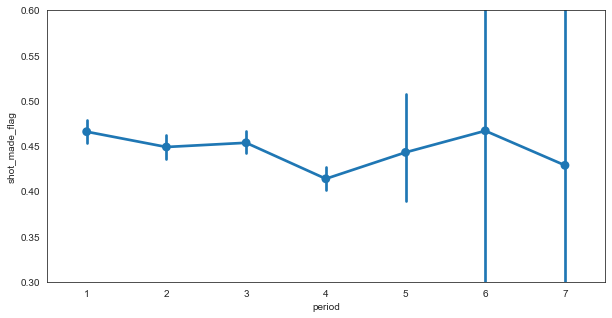

In [19]:
fig = plt.figure(figsize=(10, 5))
sns.pointplot(x='period', y='shot_made_flag', data=kb)
plt.ylim(0.3, 0.6)
plt.show()

Let's group the all the overtime periods (above 4) into one 5th period which will correspond to a generalized over-time value.

In [20]:
kb.loc[kb['period'] > 4, 'period'] = 5

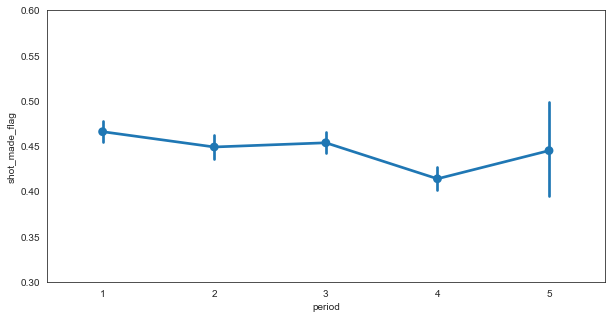

In [21]:
fig = plt.figure(figsize=(10, 5))
sns.pointplot(x='period', y='shot_made_flag', data=kb)
plt.ylim(0.3, 0.6)
plt.show()

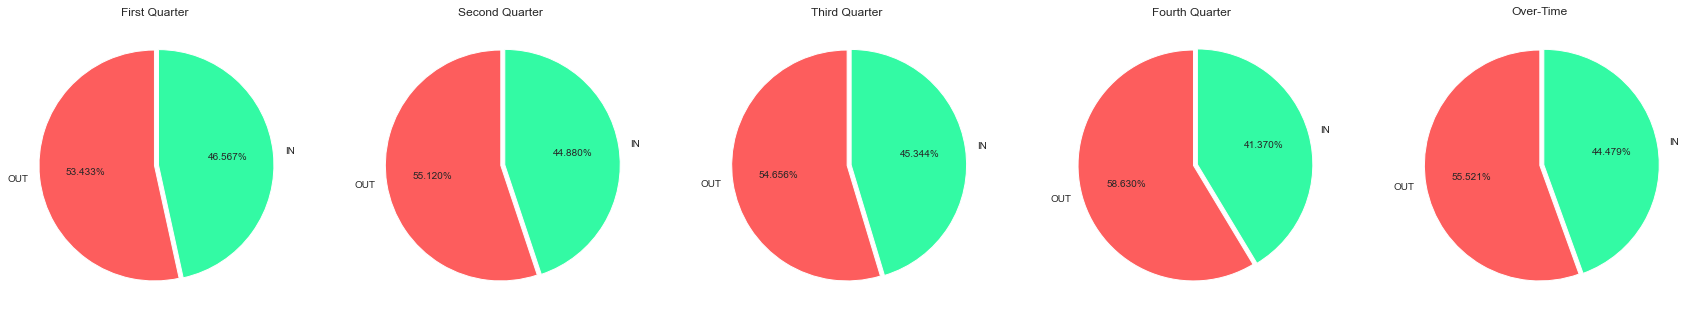

In [22]:
fig, ax = plt.subplots(figsize=(30, 30))
class_ = ['OUT', 'IN']
percentage=[]

plt.subplot(1,5,1)
s_type = kb.loc[kb['period'] == 1, 'shot_made_flag'].value_counts().sort_index().values
colors = ['#fd5d5d','#33faa4']
plt.pie(s_type, labels=class_, colors=colors, autopct = '%1.3f%%', explode=(0, 0.035), startangle=90)
plt.title('First Quarter')

plt.subplot(1,5,2)
s_type = kb.loc[kb['period'] == 2, 'shot_made_flag'].value_counts().sort_index().values
colors = ['#fd5d5d','#33faa4']
plt.pie(s_type, labels=class_, colors=colors, autopct = '%1.3f%%', explode=(0, 0.035), startangle=90)
plt.title('Second Quarter')

plt.subplot(1,5,3)
s_type = kb.loc[kb['period'] == 3, 'shot_made_flag'].value_counts().sort_index().values
colors = ['#fd5d5d','#33faa4']
plt.pie(s_type, labels=class_, colors=colors, autopct = '%1.3f%%', explode=(0, 0.035), startangle=90)
plt.title('Third Quarter')

plt.subplot(1,5,4)
s_type = kb.loc[kb['period'] == 4, 'shot_made_flag'].value_counts().sort_index().values
colors = ['#fd5d5d','#33faa4']
plt.pie(s_type, labels=class_, colors=colors, autopct = '%1.3f%%', explode=(0, 0.035), startangle=90)
plt.title('Fourth Quarter ')

plt.subplot(1,5,5)
s_type = kb.loc[kb['period'] == 5, 'shot_made_flag'].value_counts().sort_index().values
colors = ['#fd5d5d','#33faa4']
plt.pie(s_type, labels=class_, colors=colors, autopct = '%1.3f%%', explode=(0, 0.035), startangle=90)
plt.title('Over-Time')

plt.show()

It seems that Kobe's accuracy tends to be slightly lower near the end of the game which might be due to being tired or because of a higher percentage of 3 pointers attempted to make a comeback on losing games but also seems to go up on Over-Time when difference in points between teams might be narrow, therefore securing shots is of great importance at that phase of a game.

## Analyzing different shot types

### Shots efectiveness per combined_shot_type

In [23]:
cste = ps.sqldf('''
select 
    combined_shot_type,
    count(*) Count,
    sum(shot_made_flag) / count(*) Effectiveness
from kb
group by combined_shot_type
order by Count desc''')

cste

,combined_shot_type,Count,Effectiveness
0,Jump Shot,23485,0.328209
1,Layup,5448,0.470081
2,Dunk,1286,0.762053
3,Tip Shot,184,0.288043
4,Hook Shot,153,0.444444
5,Bank Shot,141,0.673759


Text(0, 0.5, '')

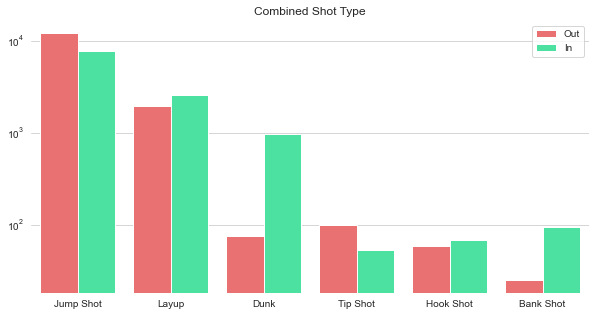

In [24]:
sns.set_style(style='whitegrid')
fig, ax = plt.subplots(figsize=(10, 5))
sns.countplot(kb['combined_shot_type'], palette={1:'#33faa4', 0:'#fd5d5d'}, hue=kb['shot_made_flag'],  dodge=True, log = True)
sns.despine(fig=None, ax=None, top=True, right=True, left=True, bottom=True, offset=True, trim=True)
plt.title('Combined Shot Type')
ax.legend(labels=['Out', 'In'])
ax.set_xlabel('')
ax.set_ylabel('')

### Shots Accuracy per combined_shot_type

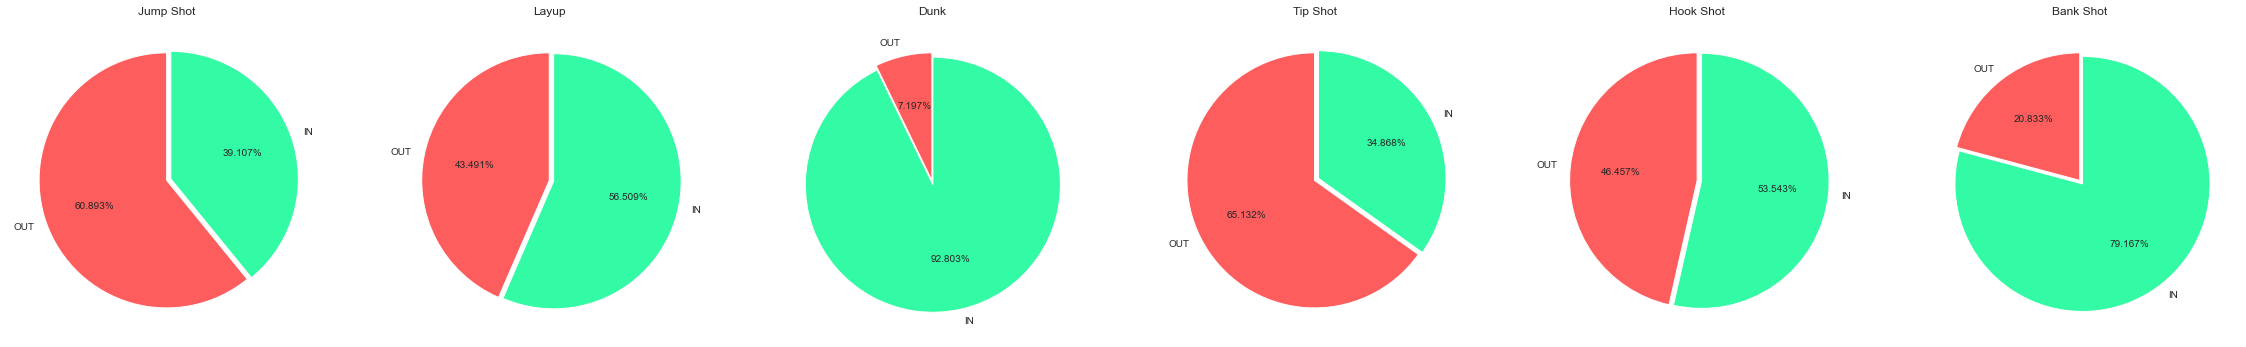

In [25]:
fig, ax = plt.subplots(figsize=(40, 40))
percentage=[]
class_ = ['OUT', 'IN']

for ind, zone in zip(range(1,7), kb['combined_shot_type'].value_counts().sort_values(ascending=False).index):    
    
    plt.subplot(1,6,ind)
    s_type = kb.loc[kb['combined_shot_type']==zone, 'shot_made_flag'].value_counts().sort_index().values
    colors = ['#fd5d5d','#33faa4']
    plt.pie(s_type, labels=class_, colors=colors, autopct = '%1.3f%%', explode=(0, 0.035), startangle=90)
    plt.title(zone)


By looking at thre graphs above we can see that the most common of shot taken by Kobe were jumpshots, while he was extremely effective on dunks, layups and bankshots, he still scored more jumpshots than any other type of shot.

### Shot effectiveness per action_type

In [26]:
ate = ps.sqldf('''
select
    combined_shot_type,
    action_type,
    count(*) Count,
    coalesce(sum(shot_made_flag), 0) / count(*) Effectiveness
from kb
group by action_type
order by combined_shot_type asc, effectiveness desc''')

ate

,combined_shot_type,action_type,Count,Effectiveness
0,Bank Shot,Hook Bank Shot,5,1.000000
1,Bank Shot,Running Bank shot,48,0.750000
2,Bank Shot,Turnaround Bank shot,71,0.647887
3,Bank Shot,Pullup Bank shot,12,0.500000
4,Bank Shot,Driving Bank shot,5,0.400000
5,Dunk,Running Slam Dunk Shot,1,1.000000
6,Dunk,Reverse Slam Dunk Shot,16,0.937500
7,Dunk,Driving Slam Dunk Shot,48,0.875000
8,Dunk,Running Dunk Shot,19,0.842105
9,Dunk,Driving Dunk Shot,310,0.809677


In [27]:
ps.sqldf('''
select 
    ate.combined_shot_type combined_shot_type,
    cste.Count cst_count,
    cste.Effectiveness cst_effectiveness, 
    ate.action_type action_type,
    ate.Count at_count,
    ate.Effectiveness at_effectiveness,
    ate.Count / cast(cste.Count as float) cst_proportion 
from ate
inner join cste 
on ate.combined_shot_type = cste.combined_shot_type
order by 
    combined_shot_type asc,
    cst_proportion desc,
    at_effectiveness desc
''')

,combined_shot_type,cst_count,cst_effectiveness,action_type,at_count,at_effectiveness,cst_proportion
0,Bank Shot,141,0.673759,Turnaround Bank shot,71,0.647887,0.503546
1,Bank Shot,141,0.673759,Running Bank shot,48,0.750000,0.340426
2,Bank Shot,141,0.673759,Pullup Bank shot,12,0.500000,0.085106
3,Bank Shot,141,0.673759,Hook Bank Shot,5,1.000000,0.035461
4,Bank Shot,141,0.673759,Driving Bank shot,5,0.400000,0.035461
5,Dunk,1286,0.762053,Slam Dunk Shot,411,0.798054,0.319596
6,Dunk,1286,0.762053,Driving Dunk Shot,310,0.809677,0.241058
7,Dunk,1286,0.762053,Dunk Shot,262,0.645038,0.203733
8,Dunk,1286,0.762053,Alley Oop Dunk Shot,122,0.737705,0.094868
9,Dunk,1286,0.762053,Reverse Dunk Shot,75,0.746667,0.058320


Above we can see a table that shows how the action_type is grouped by the combined_shot_type and it shows clearly how certain types of jumpshots or have a drastic difference in effectiveness.

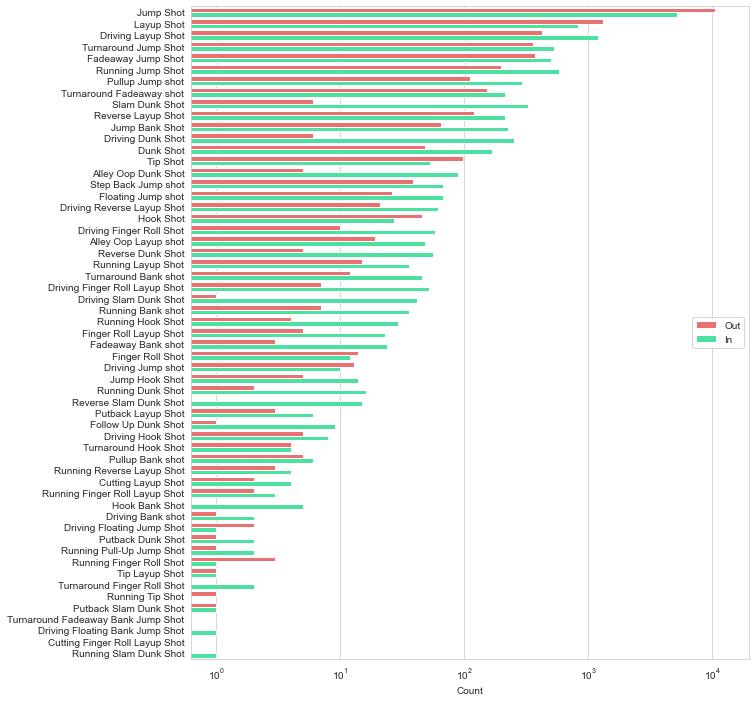

In [28]:
sns.set_style(style='whitegrid')
plt.figure(figsize=(10, 12))
sns.countplot(y='action_type', data=kb, order=kb['action_type'].value_counts().index, log=True, hue='shot_made_flag', palette={1:'#33faa4', 0:'#fd5d5d'})
plt.xlim(xmax=20000)
plt.legend(labels=['Out', 'In'])
plt.ylabel('')
plt.xlabel('Count')
plt.show()

From the cell above we can see:
* Each action_type corresponds to a single combined_shot_type, in other words, a combined_shot_type value can have different values for action_type and not the other way around.

* The action_type column is more detailed than combined_shot_type, and does provide more information on the accuracy Kobe had in different type of shots but it is too granular and therefore we'll convert the shots with a count lower than 120 shots into 'Other'.

* Even though they seem redundant we'll keep both action_type and combined_shot_type because when one feature might not help our model, the other one will be available, both of them contain unique values that can be very useful and some that may not, this way we'll keep all of them and those that are not so useful will be removed when we select our top features.

In [29]:
#replacing every value that occurs less than 100 times with the value 'Other' 
kb.loc[kb.groupby('action_type').action_type.transform('count').lt(120), 'action_type'] = 'Other'

#deleting the word shot from all the values, deleting any spaces at the beginning or end, and turning it into title case where each word is capitalized just to make it cleaner
kb['action_type'] = kb['action_type'].str.strip().str.title()

### Shot accuracy per action_type

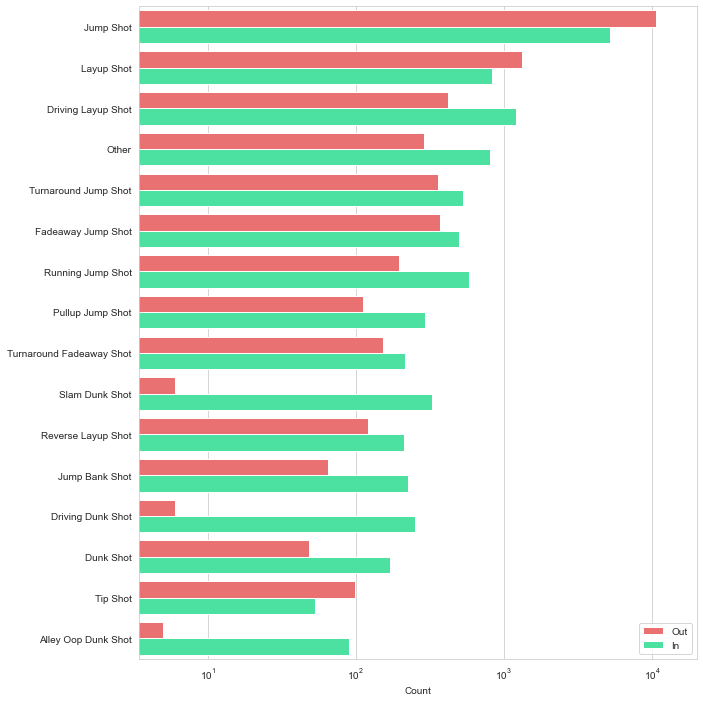

In [30]:
sns.set_style(style='whitegrid')
plt.figure(figsize=(10, 12))
sns.countplot(y='action_type', data=kb, order=kb['action_type'].value_counts().index, log=True, hue='shot_made_flag', palette={1:'#33faa4', 0:'#fd5d5d'})
plt.xlim(xmax=20000)
plt.legend(labels=['Out', 'In'])
plt.ylabel('')
plt.xlabel('Count')
plt.show()

Now the feature seems less granular while still containing detailed information.

#### 2-pointers vs 3-pointers

In [31]:
ps.sqldf('''
select 
    shot_type,
    cast(sum(shot_made_flag) as int) as Scored,
    count(*) as Count,
    sum(shot_made_flag) / count(*) as Effectiveness
from kb
group by shot_type
order by Count desc''')

,shot_type,Scored,Count,Effectiveness
0,2PT Field Goal,9683,24271,0.398953
1,3PT Field Goal,1782,6426,0.277311


Text(0.5, 1.0, 'Shot Attempts by zone ranges')

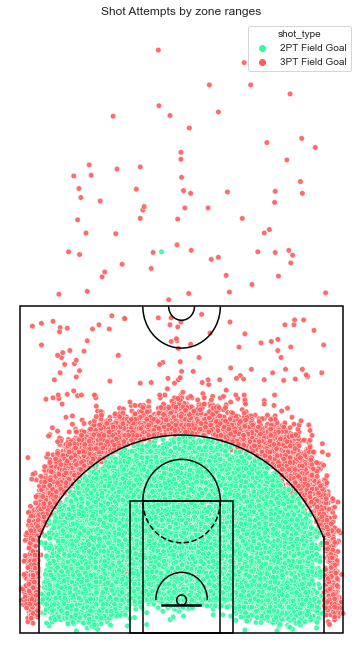

In [32]:
fig, ax = plt.subplots(figsize=(6.25, 11.75))
g = sns.scatterplot(data=kb, x='loc_x', y='loc_y', hue='shot_type', s=30, palette={'2PT Field Goal':'#33faa4', '3PT Field Goal':'#fd5d5d'}, alpha=0.9)
sns.despine(fig=None, ax=None, top=True, right=True, left=True, bottom=True, offset=None, trim=True)
g.set(yticks=[], xticks=[])
ax.set_ylabel('')    
ax.set_xlabel('')
draw_court(outer_lines=True); plt.xlim(270,-270); plt.title('Shot Attempts by zone ranges')
#fig.savefig('kobe_shot_zone_ranges.png')

If we take a close look, there is a 2PT Field Goal shot behind the back court which seems to be the only relevant error in our data.

In [33]:
kb[(kb['shot_type']=='2PT Field Goal') & (kb['shot_distance'] > 24)]

,action_type,combined_shot_type,lat,loc_x,loc_y,lon,period,playoffs,season,shot_distance,shot_made_flag,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,game_date,matchup,opponent,shot_id,month,time_remaining
10320,Jump Shot,Jump Shot,33.5433,31,501,-118.2388,2,0,2003-04,50,0.0,2PT Field Goal,Back Court(BC),Backcourt,Back Court Shot,2003-11-28 00:00:00.000000,LAL vs. SAS,SAS,5251,0,0
14633,Jump Shot,Jump Shot,33.8343,159,210,-118.1108,4,0,2005-06,26,1.0,2PT Field Goal,Right Side Center(RC),Above the Break 3,24+ ft.,2006-03-06 00:00:00.000000,LAL vs. SAS,SAS,9104,4,265


There seems to be a mistake here a shot cant be both a 2pt field goal and a back court shot or a 24+ft, the maximum distance from the hoop to the 3pt line is 23ft and 9", everything above 24 feet will be set to a 3PT Field Goal but not everything below 24ft is a 2PT Field Goal, although these couple of fields seem to be the only mistake it's safe to say that everything above that distance is a 3-pointer.

In [34]:
kb.loc[kb['shot_distance'] > 24, 'shot_type']='3PT Field Goal'

Text(0.5, 1.0, 'Shot Attempts by zone ranges')

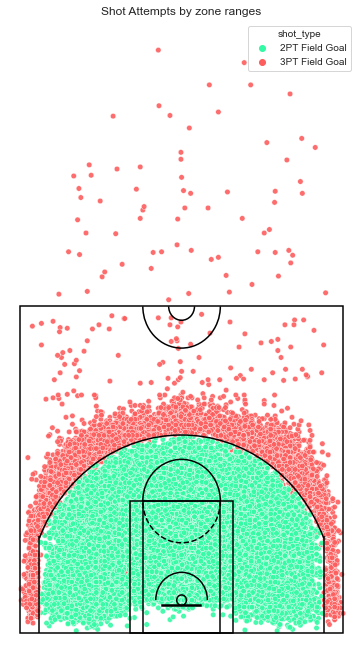

In [35]:
fig, ax = plt.subplots(figsize=(6.25, 11.75))
g = sns.scatterplot(data=kb, x='loc_x', y='loc_y', hue='shot_type', s=30, palette={'2PT Field Goal':'#33faa4', '3PT Field Goal':'#fd5d5d'}, alpha=0.9)
sns.despine(fig=None, ax=None, top=True, right=True, left=True, bottom=True, offset=None, trim=True)
g.set(yticks=[], xticks=[])
ax.set_ylabel('')    
ax.set_xlabel('')
draw_court(outer_lines=True); plt.xlim(270,-270); plt.title('Shot Attempts by zone ranges')
#fig.savefig('kobe_shot_zone_ranges.png')

That seems to be more accurate.

### Shot frequency and accuracy per shot_type

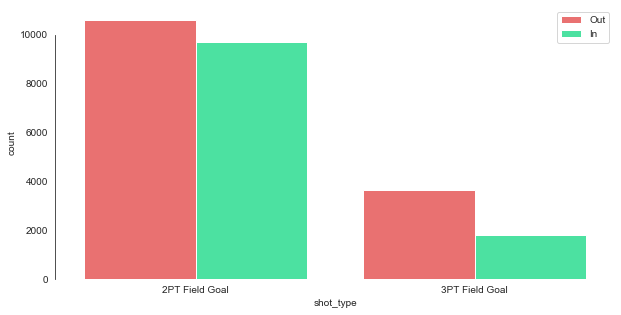

In [36]:
sns.set_style(style='white')
fig, ax = plt.subplots(figsize=(10, 5))
sns.countplot(kb['shot_type'], hue=kb['shot_made_flag'], palette={1:'#33faa4', 0:'#fd5d5d'})
sns.despine(fig=None, ax=None, top=True, right=True, left=False, bottom=True, offset=True, trim=True)
ax.legend(labels=['Out', 'In'])

### Shot Accuracy per shot_type

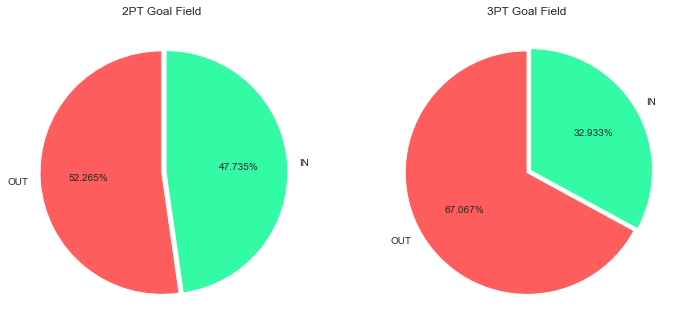

In [37]:
fig, ax = plt.subplots(figsize=(12, 12))

percentage=[]
class_ = ['OUT', 'IN']

plt.subplot(1,2,1)
s_type = kb.loc[kb['shot_type']=='2PT Field Goal', 'shot_made_flag'].value_counts().sort_index().values
colors = ['#fd5d5d','#33faa4']
plt.pie(s_type, labels=class_, colors=colors, autopct = '%1.3f%%', explode=(0, 0.035), startangle=90)
plt.title('2PT Goal Field')

plt.subplot(1,2,2)
s_type = kb.loc[kb['shot_type']=='3PT Field Goal', 'shot_made_flag'].value_counts().sort_index().values
colors = ['#fd5d5d','#33faa4']
plt.pie(s_type, labels=class_, colors=colors, autopct = '%1.3f%%', explode=(0, 0.035), startangle=90)
plt.title('3PT Goal Field')

plt.show()

## Analyzing shot accuracy per opponent

### Shot count and effectiveness by matchup

In [38]:
ps.sqldf('''
select
    matchup,
    opponent, 
    coalesce(cast(sum(shot_made_flag) as int),0) as Scored, 
    count(*) as Count, 
    coalesce(sum(shot_made_flag) / count(*), 0) as Effectiveness
from kb
group by 
    matchup
order by 
     opponent,
     Effectiveness desc
limit 15
''')

,matchup,opponent,Scored,Count,Effectiveness
0,LAL vs. ATL,ATL,90,218,0.412844
1,LAL @ ATL,ATL,108,301,0.358804
2,LAL vs. BKN,BKN,6,15,0.400000
3,LAL @ BKN,BKN,12,40,0.300000
4,LAL vs. BOS,BOS,147,421,0.349169
5,LAL @ BOS,BOS,175,525,0.333333
6,LAL @ CHA,CHA,84,223,0.376682
7,LAL vs. CHA,CHA,80,224,0.357143
8,LAL vs. CHH,CHA,33,102,0.323529
9,LAL @ CHH,CHA,21,71,0.295775


The matchup column tells us for each shot Kobe took, the opponent. But it also provides us with information on which team played at home and which one was on the road.

If Lakers game took place at their stadium, the value will be "LAL vs. Team", when Lakers visit the other team it is represented as "LAL @ Team"

We already have a column to represent Lakers opponent for each shot in the dataset, therefore we will only create a column which will represent wether or not Lakers played at home (1) or on the road (0) and drop the matchup column.

In [39]:
kb.loc[kb['matchup'].str.contains('@'), 'home'] = 0 #when the matchup value contains a @ the value will be 0. This means Lakers played at the other team's stadium
kb.loc[kb['matchup'].str.contains('vs.'), 'home'] = 1 #when the matchup value contains a vs. the value will be 1. This Means Lakers did play at home
kb.drop(columns='matchup', inplace=True) #drop the matchup column

### Shot Accuracy (Home vs Away)

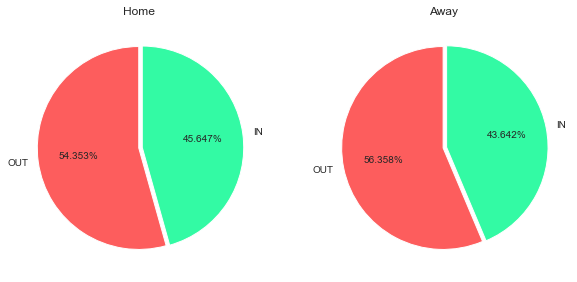

In [40]:
fig, ax = plt.subplots(figsize=(10, 10))

percentage=[]
class_ = ['OUT', 'IN']

plt.subplot(1,2,1)
s_type = kb.loc[kb['home']==1, 'shot_made_flag'].value_counts().sort_index().values
colors = ['#fd5d5d','#33faa4']
plt.pie(s_type, labels=class_, colors=colors, autopct = '%1.3f%%', explode=(0, 0.035), startangle=90)
plt.title('Home')

plt.subplot(1,2,2)
s_type = kb.loc[kb['home']==0, 'shot_made_flag'].value_counts().sort_index().values
colors = ['#fd5d5d','#33faa4']
plt.pie(s_type, labels=class_, colors=colors, autopct = '%1.3f%%', explode=(0, 0.035), startangle=90)
plt.title('Away')

plt.show()

Doesn't seem to be a great feature but we'll keep for now, even if when we might drop it later.

### Shot count and effectiveness by opponent

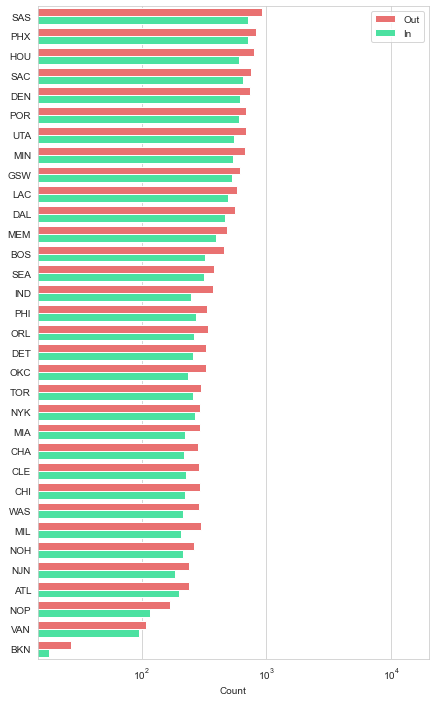

In [41]:
sns.set_style(style='whitegrid')
plt.figure(figsize=(7, 12))
sns.countplot(y='opponent', data=kb, order=kb['opponent'].value_counts().index, log=True, hue='shot_made_flag', palette={1:'#33faa4', 0:'#fd5d5d'})
plt.xlim(xmax=20000)
plt.legend(labels=['Out', 'In'])
plt.ylabel('')
plt.xlabel('Count')
plt.show()

In [42]:
ps.sqldf('''
select 
    opponent,
    coalesce(sum(shot_made_flag), 0) Scored,
    count(*) Count,
    coalesce(sum(shot_made_flag), 0) / count(*) Effectiveness
from kb
group by opponent
order by Count desc''')

,opponent,Scored,Count,Effectiveness
0,SAS,715.0,1978,0.361476
1,PHX,713.0,1781,0.400337
2,HOU,608.0,1666,0.364946
3,SAC,650.0,1643,0.395618
4,DEN,619.0,1642,0.376979
5,POR,601.0,1539,0.390513
6,UTA,550.0,1490,0.369128
7,MIN,542.0,1474,0.367707
8,GSW,531.0,1356,0.391593
9,LAC,495.0,1285,0.385214


Let's find out the variance in the effectiveness against all the teams he played.

In [43]:
ps.sqldf('''
select 
    opponent,
    coalesce(sum(shot_made_flag), 0) Scored,
    count(*) Count,
    coalesce(sum(shot_made_flag), 0) / count(*) Effectiveness
from kb
group by opponent
order by Count desc''')['Effectiveness'].var()

0.00041275596414267553

Since the variance of the effectiveness against each team is too low and it will turn into more than 30 features after getting dummies, we will remove the opponent feature.

## Analyzing Shot positions.

#### Shot Distance

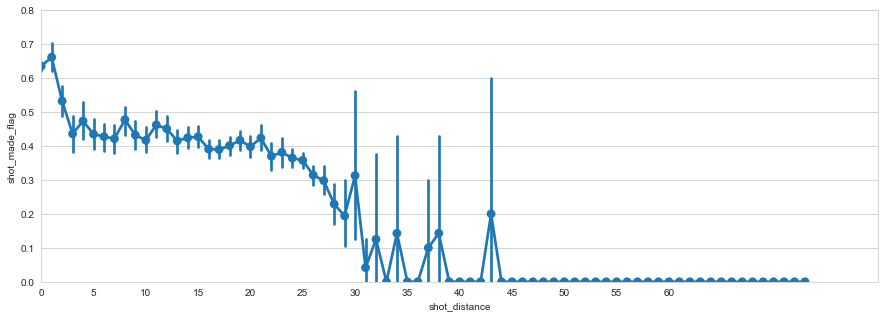

In [44]:
plt.figure(figsize=(15, 5))
sns.pointplot(x='shot_distance', y='shot_made_flag', data=kb)
plt.xlim(0, 80)
plt.ylim(0, 0.8)
plt.xticks(np.arange(0, 65, 5), np.arange(0, 65, 5))
plt.show()

Shot_distance seems a little bit noisy too but it could clearly help our model distinguish which shots went in and which didn't so we will make bins out of it

In [45]:
kb['shot_distance'] = pd.cut(kb['shot_distance'], 20, labels=range(20))

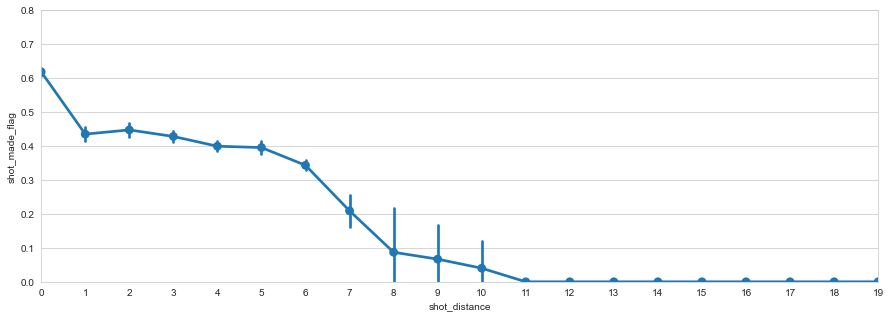

In [46]:
plt.figure(figsize=(15, 5))
sns.pointplot(x='shot_distance', y='shot_made_flag', data=kb)
plt.xlim(0, 19)
plt.ylim(0, 0.8)
plt.show()

#### Shot Zones, Areas and Ranges

Text(0.5, 1.0, 'Shot Attempts by zone ranges')

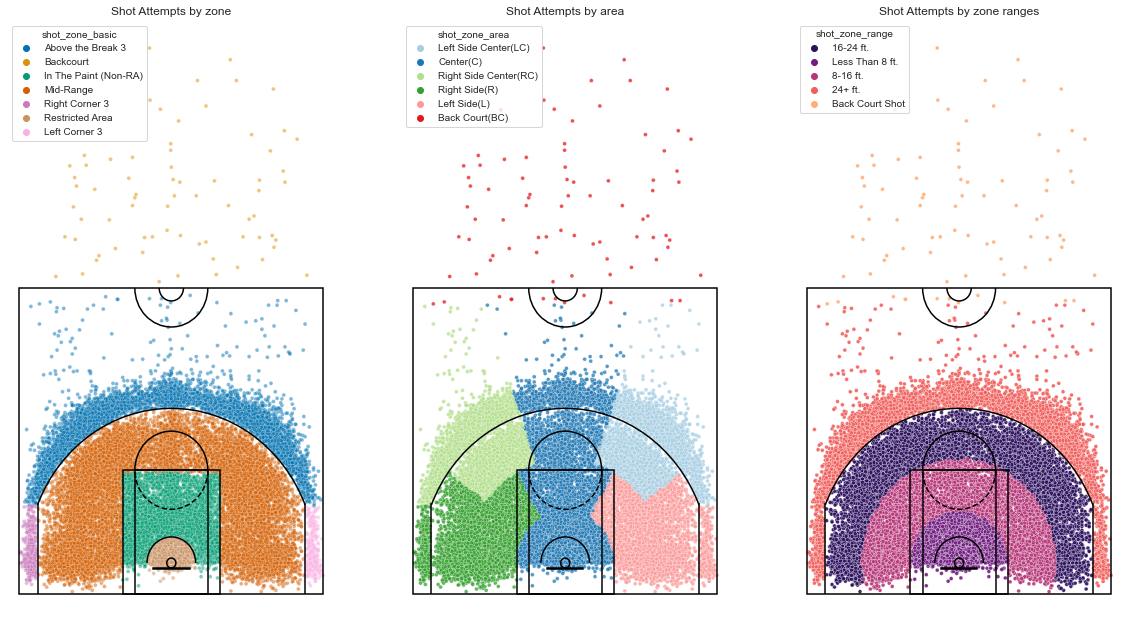

In [47]:
fig, ax = plt.subplots(figsize=(20, 11))

plt.subplot(1, 3, 1)
h_order = ['Above the Break 3', 'Backcourt', 'In The Paint (Non-RA)', 'Mid-Range', 'Right Corner 3', 'Restricted Area', 'Left Corner 3']
g1 = sns.scatterplot(data=kb, x='loc_x', y='loc_y', hue='shot_zone_basic', hue_order=h_order, s=15, palette='colorblind', alpha=.5)
sns.despine(fig=None, ax=None, top=True, right=True, left=True, bottom=True, offset=None, trim=True)
g1.set(yticks=[], xticks=[])
g1.set_ylabel('')    
g1.set_xlabel('')
draw_court(outer_lines=True); plt.xlim(270,-270); plt.title('Shot Attempts by zone')
#fig.savefig('kobe_shot_zone_basic.png')

plt.subplot(1, 3, 2)
g2 = sns.scatterplot(data=kb, x='loc_x', y='loc_y', hue='shot_zone_area', s=15, palette='Paired', alpha=.75)
sns.despine(fig=None, ax=None, top=True, right=True, left=True, bottom=True, offset=None, trim=True)
g2.set(yticks=[], xticks=[])
g2.set_ylabel('')    
g2.set_xlabel('')
draw_court(outer_lines=True); plt.xlim(270,-270); plt.title('Shot Attempts by area')

plt.subplot(1, 3, 3)
h_order=['Back Court Shot', '24+ ft.', '16-24 ft.', '8-16 ft.', 'Less Than 8 ft.']
g3 = sns.scatterplot(data=kb, x='loc_x', y='loc_y', hue='shot_zone_range', hue_order=h_order.reverse(), s=15, palette='magma', alpha=0.9)
sns.despine(fig=None, ax=None, top=True, right=True, left=True, bottom=True, offset=None, trim=True)
g3.set(yticks=[], xticks=[])
g3.set_ylabel('')    
g3.set_xlabel('')
draw_court(outer_lines=True); plt.xlim(270,-270); plt.title('Shot Attempts by zone ranges')

The plots above don't provide information on his effectiveness but allow us to visualize the different zones provided by each feature.

### Shot count and effectiveness by shot_zone_basic

In [48]:
ps.sqldf('''
select 
    shot_zone_basic, 
    count(*) as Count,
    sum(shot_made_flag) / count(*) as Effectiveness
from kb
group by shot_zone_basic
order by Effectiveness desc''')

,shot_zone_basic,Count,Effectiveness
0,Restricted Area,7136,0.513733
1,In The Paint (Non-RA),4578,0.385103
2,Mid-Range,12625,0.338931
3,Left Corner 3,280,0.317857
4,Right Corner 3,387,0.291990
5,Above the Break 3,5620,0.276512
6,Backcourt,71,0.014085


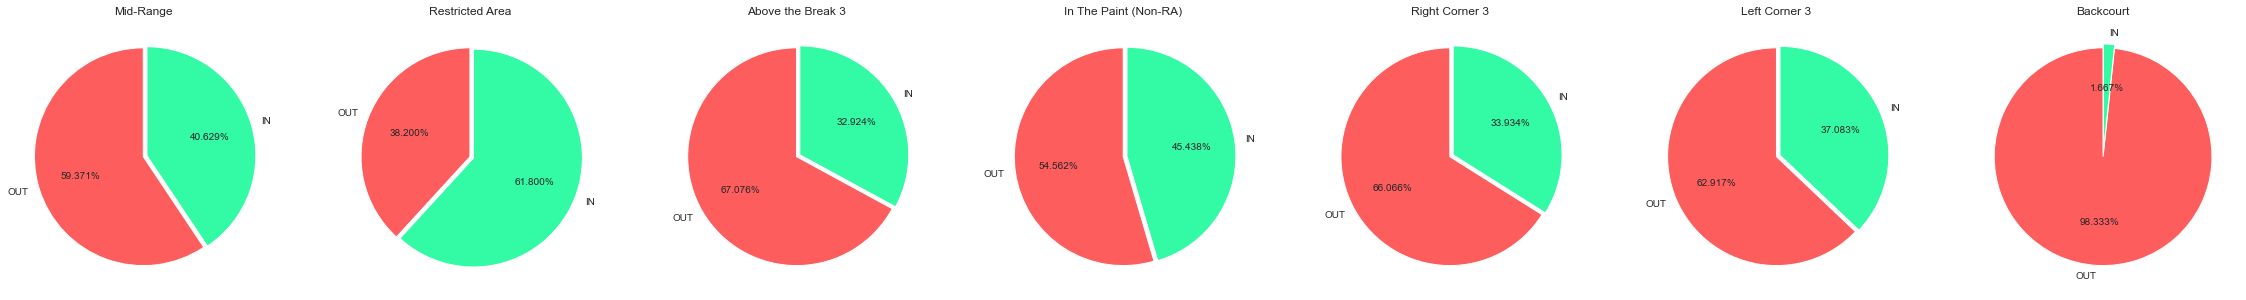

In [49]:
fig, ax = plt.subplots(figsize=(40, 40))
percentage=[]
class_ = ['OUT', 'IN']

for ind, zone in zip(range(1,8), kb['shot_zone_basic'].value_counts().sort_values(ascending=False).index):    
    
    plt.subplot(1,7,ind)
    s_type = kb.loc[kb['shot_zone_basic']==zone, 'shot_made_flag'].value_counts().sort_index().values
    colors = ['#fd5d5d','#33faa4']
    plt.pie(s_type, labels=class_, colors=colors, autopct = '%1.3f%%', explode=(0, 0.035), startangle=90)
    plt.title(zone)


### Shot count and effectiveness by shot_zone_area

In [50]:
ps.sqldf('''
select 
    shot_zone_area, 
    count(*) as Count, 
    sum(shot_made_flag) / count(*) as Effectiveness
from kb
group by shot_zone_area
order by Effectiveness desc''')

,shot_zone_area,Count,Effectiveness
0,Center(C),13455,0.440951
1,Right Side(R),4588,0.337838
2,Left Side(L),3751,0.331378
3,Right Side Center(RC),4776,0.318886
4,Left Side Center(LC),4044,0.300445
5,Back Court(BC),83,0.012048


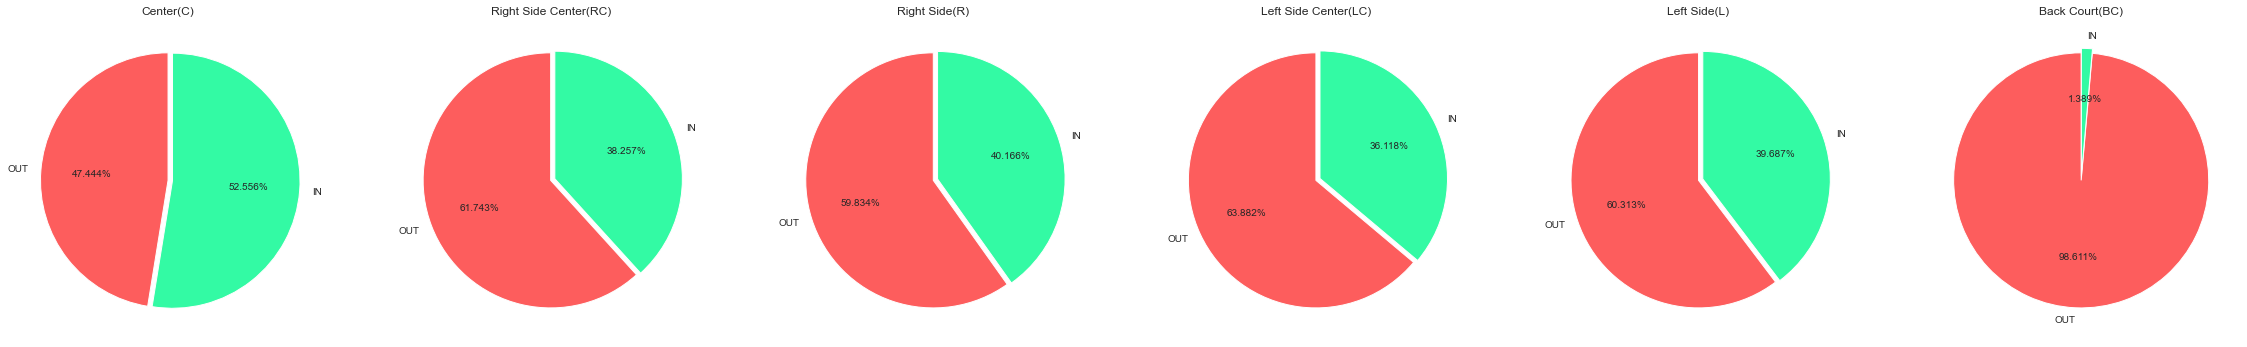

In [51]:
fig, ax = plt.subplots(figsize=(40, 40))
percentage=[]
class_ = ['OUT', 'IN']

for ind, zone in zip(range(1,7), kb['shot_zone_area'].value_counts().sort_values(ascending=False).index):    
    
    plt.subplot(1,6,ind)
    s_type = kb.loc[kb['shot_zone_area']==zone, 'shot_made_flag'].value_counts().sort_index().values
    colors = ['#fd5d5d','#33faa4']
    plt.pie(s_type, labels=class_, colors=colors, autopct = '%1.3f%%', explode=(0, 0.035), startangle=90)
    plt.title(zone)

### Shot count and effectiveness by shot_zone_range

In [52]:
ps.sqldf('''
select 
    shot_zone_range,
    count(*) as Count, 
    sum(shot_made_flag) / count(*) as Effectiveness
from kb
group by shot_zone_range
order by Effectiveness desc''')

,shot_zone_range,Count,Effectiveness
0,Less Than 8 ft.,9398,0.479144
1,8-16 ft.,6626,0.366737
2,16-24 ft.,8315,0.333734
3,24+ ft.,6275,0.279841
4,Back Court Shot,83,0.012048


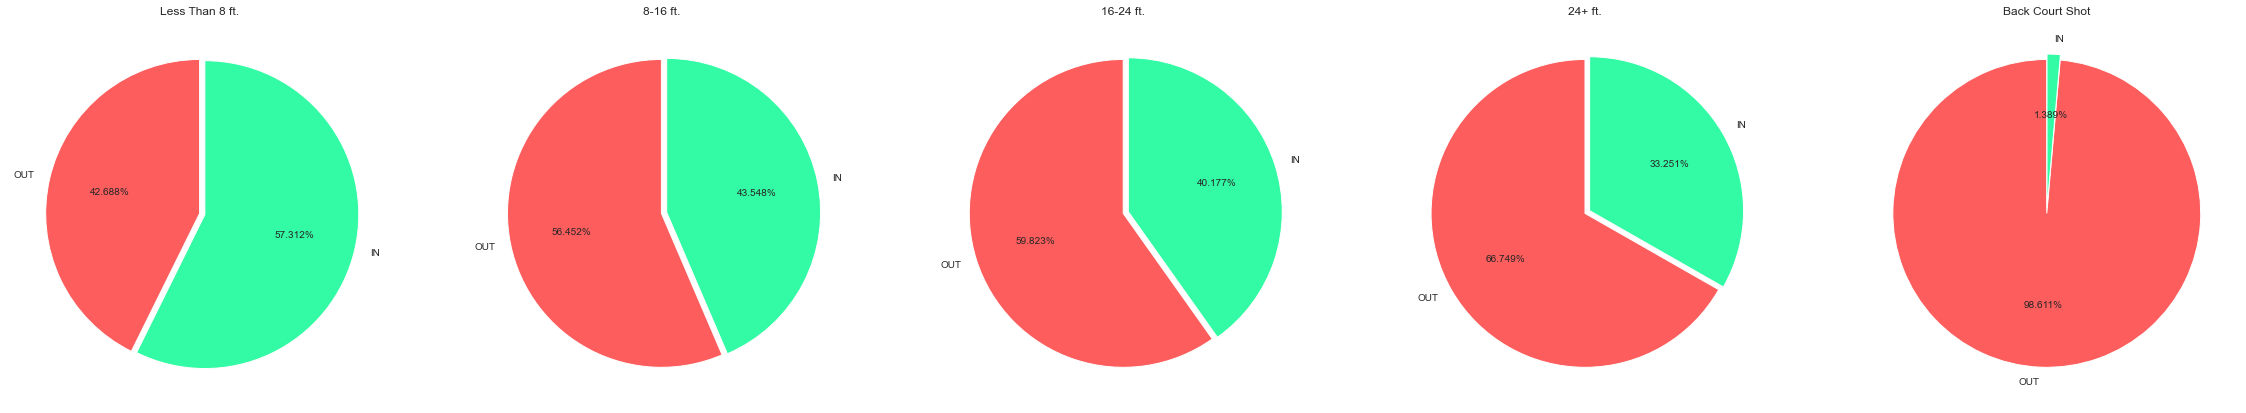

In [53]:
fig, ax = plt.subplots(figsize=(40, 40))
percentage=[]
class_ = ['OUT', 'IN']
ranges = ['Less Than 8 ft.', '8-16 ft.', '16-24 ft.', '24+ ft.', 'Back Court Shot']

for ind, zone in zip(range(1,6), ranges):    
    
    plt.subplot(1,5,ind)
    s_type = kb.loc[kb['shot_zone_range']==zone, 'shot_made_flag'].value_counts().sort_index().values
    colors = ['#fd5d5d','#33faa4']
    plt.pie(s_type, labels=class_, colors=colors, autopct = '%1.3f%%', explode=(0, 0.035), startangle=90)
    plt.title(zone)


#### We'll also create a feature representing the angle at which each shot was taken and get bins out of it.

In [54]:
kb['angle'] = np.arctan(kb.loc_x/kb.loc_y)
kb['angle'].fillna(0, inplace=True)

asteps = 5
kb['angle_bin'] = pd.cut(kb.angle, asteps, labels=np.arange(asteps) - asteps//2)
kb.drop(columns='angle', inplace=True)

In [55]:
angle_map={
    -2:'Left',
    -1:'Left-Center',
    0:'Center',
    1:'Right-Center',
    2:'Right'}
    
kb['angle_bin'] = kb['angle_bin'].map(angle_map)

#### Let's see how those angles look on the court

Text(0.5, 1.0, 'Shot Attempts by zone ranges')

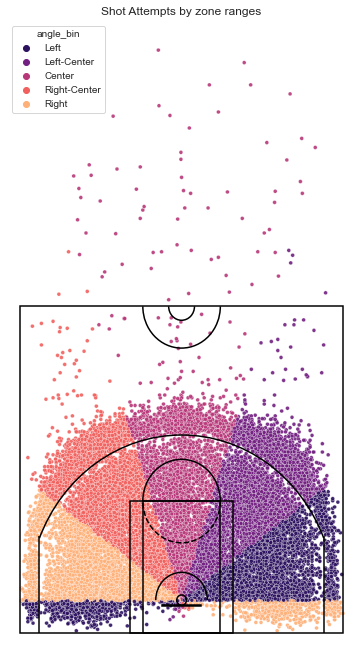

In [56]:
fig = plt.figure(figsize=(6.25, 11.75))
g3 = sns.scatterplot(data=kb, x='loc_x', y='loc_y', hue='angle_bin', s=15, palette='magma', alpha=0.9)
sns.despine(fig=None, ax=None, top=True, right=True, left=True, bottom=True, offset=None, trim=True)
g3.set(yticks=[], xticks=[])
g3.set_ylabel('')    
g3.set_xlabel('')
draw_court(outer_lines=True); plt.xlim(270,-270); plt.title('Shot Attempts by zone ranges')

### Shot count and effectiveness by angle_bin

In [57]:
ps.sqldf('''
select 
    angle_bin, 
    coalesce(cast(sum(shot_made_flag) as int),0) as Scored, 
    count(*) as Count, 
    coalesce(sum(shot_made_flag) / count(*), 0) as Effectiveness
from kb
group by angle_bin
order by Count desc
''')

,angle_bin,Scored,Count,Effectiveness
0,Center,4351,9733,0.447036
1,Right-Center,2215,6487,0.341452
2,Left-Center,1818,5529,0.328812
3,Right,1644,4690,0.350533
4,Left,1437,4258,0.337482


#### Shot Accuracy by angle bin

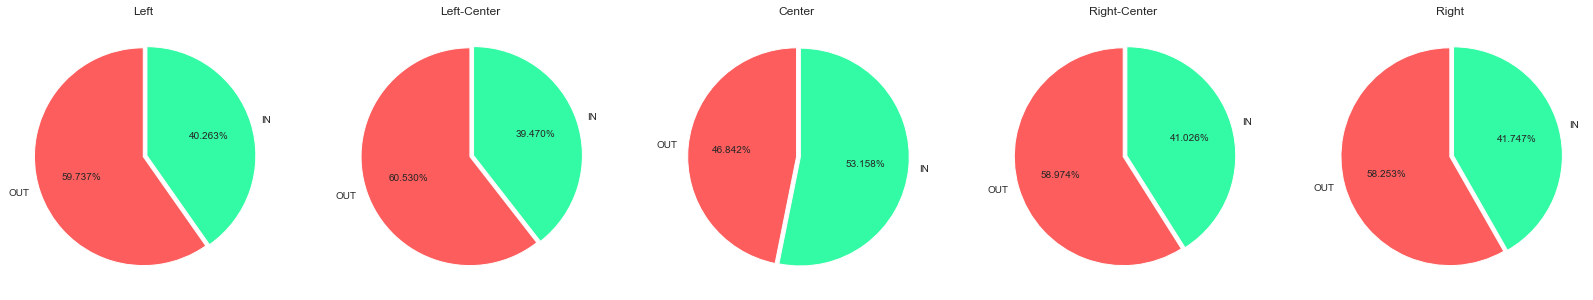

In [58]:
fig, ax = plt.subplots(figsize=(40, 40))
percentage=[]
class_ = ['OUT', 'IN']
angles = ['Left', 'Left-Center', 'Center', 'Right-Center', 'Right']
for ind, angle in zip(range(1, 7), angles):    
    
    plt.subplot(1,7,ind)
    s_type = kb.loc[kb['angle_bin']==angle, 'shot_made_flag'].value_counts().sort_index().values
    colors = ['#fd5d5d','#33faa4']
    plt.pie(s_type, labels=class_, colors=colors, autopct = '%1.3f%%', explode=(0, 0.035), startangle=90)
    plt.title(angle)

#### Just for exploratpry purposes, let's see the game in which Kobe took the most shots in his career as a Laker

In [59]:
ps.sqldf('''
select 
    game_date, 
    opponent,
    coalesce(cast(sum(shot_made_flag) as int),0) as Scored, 
    count(*) as Count, 
    coalesce(sum(shot_made_flag) / count(*), 0) as Effectiveness
from kb
group by game_date
order by Count desc
limit 10''')

,game_date,opponent,Scored,Count,Effectiveness
0,2016-04-13 00:00:00.000000,UTA,19,50,0.380000
1,2002-11-07 00:00:00.000000,BOS,12,47,0.255319
2,2006-01-22 00:00:00.000000,TOR,22,46,0.478261
3,2006-12-29 00:00:00.000000,CHA,17,45,0.377778
4,2008-01-14 00:00:00.000000,SEA,19,44,0.431818
5,2007-03-30 00:00:00.000000,HOU,18,44,0.409091
6,2012-12-22 00:00:00.000000,GSW,14,41,0.341463
7,2006-01-07 00:00:00.000000,LAC,17,41,0.414634
8,2003-02-14 00:00:00.000000,SAS,16,41,0.390244
9,2002-11-15 00:00:00.000000,GSW,14,40,0.350000


The game in which Kobe took the most shots was on april 13th, 2016 against Utah Jazz which also happens to be Kobe's last NBA game.

### Kobe's last NBA game

In [60]:
kb.loc[kb['game_date']=='2016-04-13', 'shot_made_flag'].value_counts(dropna=False)

Series([], Name: shot_made_flag, dtype: int64)

In [61]:
kb.loc[kb['game_date']=='2016-04-13', 'shot_type'].value_counts(dropna=False)

Series([], Name: shot_type, dtype: int64)

If we explore this game in more detail we have 21 3-pointers and 29 2-pointers, and out of all the shots 24 were missed but 19 were scored

In [62]:
kb.loc[(kb['game_date']=='2016-04-13') & (kb['shot_type']=='3PT Field Goal'), 'shot_made_flag'].sum()

0.0

Out of the 21 3 pointers Kobe scored 6 which add up to 18 points.

In [63]:
kb.loc[(kb['game_date']=='2016-04-13') & (kb['shot_type']=='2PT Field Goal'), 'shot_made_flag'].sum()

0.0

And out of the 2 pointers taken 13 went in which add 26 points.

In [64]:
26 + 18

44

Out of the data we have, he scored at least 44pts that game and we have 7 shots to predict right there.
Since I watched that game against Utah Jazz on TV I recall Kobe scoring 60pts. 

Remember that free throws are not included in the dataset.

### Seasons

In [65]:
ps.sqldf('''
select 
    season, 
    coalesce(cast(sum(shot_made_flag) as int),0) as Scored, 
    count(*) as Count, 
    coalesce(sum(shot_made_flag) / count(*), 0) as Effectiveness
from kb
group by season
order by season''')

,season,Scored,Count,Effectiveness
0,1996-97,162,477,0.339623
1,1997-98,349,989,0.352882
2,1998-99,351,921,0.381107
3,1999-00,604,1577,0.383006
4,2000-01,735,1868,0.393469
5,2001-02,783,2028,0.386095
6,2002-03,808,2241,0.360553
7,2003-04,594,1638,0.362637
8,2004-05,492,1324,0.371601
9,2005-06,873,2318,0.376618


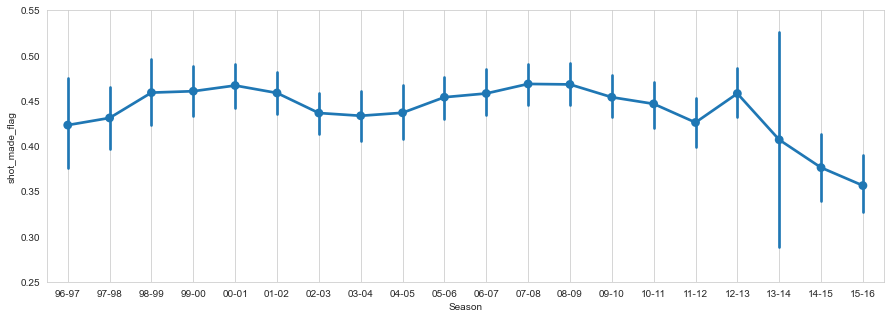

In [66]:
plt.figure(figsize=(15, 5))
sns.pointplot(x='season', y='shot_made_flag', data=kb, order=sorted(list(kb['season'].unique())))
plt.gca().set_xticklabels([x[2:] for x in sorted(list(kb['season'].unique()))])
plt.gca().set_ylim(0.25, 0.55)
plt.xlabel('Season')
plt.grid()
plt.show()

We'll turn the season into an ordinal variable. Since 1996-97 was his first season it will be turned to a number 0 and the second will be number 1 and so on.

In [67]:
#creating a list with each season as a string
season_keys = kb['season'].value_counts().sort_index().index.tolist()

#creating a list starting on number 0 up to 19
season_values = [i for i in range(20)]

#mapping each element from the season list with each element in the numeric list into a dictionary
season_map = {key:val for key, val in zip(season_keys, season_values)}

#replacing each value in the column by mapping the dictionary created above
kb['season'] = kb['season'].map(season_map)

In [68]:
ps.sqldf('''
select 
    season, 
    coalesce(cast(sum(shot_made_flag) as int),0) as Scored, 
    count(*) as Count, 
    coalesce(sum(shot_made_flag) / count(*), 0) as Effectiveness
from kb
group by season
order by season''')

,season,Scored,Count,Effectiveness
0,0,162,477,0.339623
1,1,349,989,0.352882
2,2,351,921,0.381107
3,3,604,1577,0.383006
4,4,735,1868,0.393469
5,5,783,2028,0.386095
6,6,808,2241,0.360553
7,7,594,1638,0.362637
8,8,492,1324,0.371601
9,9,873,2318,0.376618


#### Shot Frequency and Accuracy (Regular Season vs Playoffs)

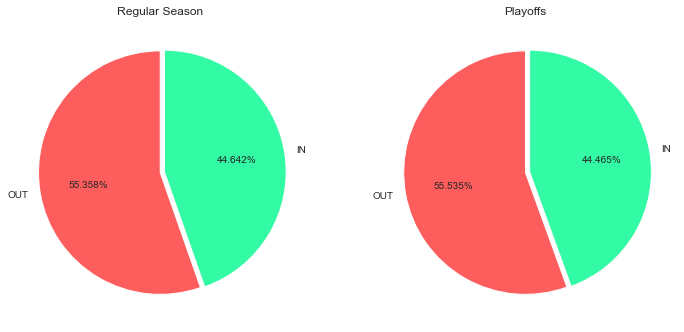

In [69]:
fig, ax = plt.subplots(figsize=(12, 12))

percentage=[]
class_ = ['OUT', 'IN']

plt.subplot(1,2,1)
s_type = kb.loc[kb['playoffs']==0, 'shot_made_flag'].value_counts().sort_index().values
colors = ['#fd5d5d','#33faa4']
plt.pie(s_type, labels=class_, colors=colors, autopct = '%1.3f%%', explode=(0, 0.035), startangle=90)
plt.title('Regular Season')

plt.subplot(1,2,2)
s_type = kb.loc[kb['playoffs']==1, 'shot_made_flag'].value_counts().sort_index().values
colors = ['#fd5d5d','#33faa4']
plt.pie(s_type, labels=class_, colors=colors, autopct = '%1.3f%%', explode=(0, 0.035), startangle=90)
plt.title('Playoffs')

plt.show()

Does not seem like a good feature because both values have a fairly similar effectiveness, but we won't drop it yet.

## Last Step
Now we'll just organize columns in a way that make more sense, grouping similar columns next to eachother

In [70]:
kb.head()

,action_type,combined_shot_type,lat,loc_x,loc_y,lon,period,playoffs,season,shot_distance,shot_made_flag,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,game_date,opponent,shot_id,month,time_remaining,home,angle_bin
0,Jump Shot,Jump Shot,33.9283,-140,116,-118.4098,1,0,0,4,0.0,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1996-11-03 00:00:00.000000,MIN,22902,0,42,1.0,Left-Center
1,Jump Shot,Jump Shot,33.9473,-131,97,-118.4008,2,0,0,4,0.0,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1996-11-05 00:00:00.000000,NYK,22903,0,608,0.0,Left-Center
2,Jump Shot,Jump Shot,33.8633,-142,181,-118.4118,2,0,0,5,1.0,3PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1996-11-06 00:00:00.000000,CHA,22904,0,517,0.0,Left-Center
3,Jump Shot,Jump Shot,34.0443,0,0,-118.2698,2,0,0,0,0.0,3PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1996-11-06 00:00:00.000000,CHA,22905,0,394,0.0,Center
4,Jump Shot,Jump Shot,33.9063,-10,138,-118.2798,2,0,0,3,1.0,2PT Field Goal,Center(C),In The Paint (Non-RA),8-16 ft.,1996-11-06 00:00:00.000000,CHA,22906,0,327,0.0,Center


In [71]:
sorted_features = ['shot_id', 'season', 'month', 'playoffs', 'home', 'period',\
                     'shot_distance', 'combined_shot_type', 'action_type','shot_type',\
                     'shot_zone_basic', 'shot_zone_area', 'shot_zone_range', 'angle_bin','shot_made_flag'] #reorder columns

In [72]:
kb = kb[sorted_features]

In [73]:
print(kb.shape)
kb.head()

(30697, 15)


,shot_id,season,month,playoffs,home,period,shot_distance,combined_shot_type,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,angle_bin,shot_made_flag
0,22902,0,0,0,1.0,1,4,Jump Shot,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,Left-Center,0.0
1,22903,0,0,0,0.0,2,4,Jump Shot,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,Left-Center,0.0
2,22904,0,0,0,0.0,2,5,Jump Shot,Jump Shot,3PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,Left-Center,1.0
3,22905,0,0,0,0.0,2,0,Jump Shot,Jump Shot,3PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,Center,0.0
4,22906,0,0,0,0.0,2,3,Jump Shot,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),8-16 ft.,Center,1.0


# Preprocessing done

We'll wrap all the process of loading and transforming the data into a python script which we will execute in the ML notebook.
This way in the next notebook we'll start off with our processed dataset.

In [74]:
%%writefile kb_load_process.py

if __name__=="__main__":

    import pandas as pd
    import pandasql as ps
    import numpy as np
    kb = pd.read_csv('kobe_shots.csv', parse_dates=['game_date']).drop(columns=['game_id', 'team_id', 'team_name'])
    
    kb.loc[kb['shot_distance'] > 24, 'shot_type']='3PT Field Goal' #fixing wrong values, every shot taken from 24 feet or more is a 3-pointer
    
    kb = ps.sqldf('''
        select *
        from kb
        order by 
            game_date asc, 
            period asc, 
            minutes_remaining desc,
            seconds_remaining''') #sorting Dataframe in chronological order
    
    kb['month'] = kb['game_date'].str[5:7] #extracting month from date feature
    kb['month'].replace(kb['month'].unique(), np.arange(len(kb['month'].unique())), inplace=True) 
    kb.drop(columns = 'game_date', inplace=True) #dropping game_date column
    
    #time features
#     kb['time_remaining'] = (kb['minutes_remaining']*60) + kb['seconds_remaining'] #creating the time_remaining feature
#     kb['time_remaining'] = pd.cut(kb['time_remaining'], 30, labels=range(30)) #binning time_remaining
#     kb.drop(columns=['minutes_remaining', 'seconds_remaining'], inplace=True) #dropping the minutes_remaining and seconds_remaining columns
    
    kb['shot_distance'] = pd.cut(kb['shot_distance'], 20, labels=range(20)) #binning shot_distance
    
    kb.loc[kb.groupby('action_type').action_type.transform('count').lt(120), 'action_type'] = 'Other' #replacing every value that occurs less than 120 times with the value 'Other'
    
    #home feature
    kb.loc[kb['matchup'].str.contains('@'), 'home'] = 0 #when the matchup value contains a @ the value will be 0. This means Lakers did not play as home-club
    kb.loc[kb['matchup'].str.contains('vs.'), 'home'] = 1 #when the matchup value contains a vs. the value will be 1. This Means Lakers did play as home-club
    kb['home'] = kb['home'].astype('int32')
    kb.drop(columns='matchup', inplace=True) #drop the matchup column
    
    #season feature
    season_keys = kb['season'].value_counts().sort_index().index.tolist() #creating a list with each season kobe played
    season_values = [i for i in range(20)] #creating a list from 0 to 19
    season_map = {key:val for key, val in zip(season_keys, season_values)} #zipping the lists created above into a dictionary

    kb['season'] = kb['season'].map(season_map) #mapping old values with new ones using the dictionary created above
    kb['season'] = kb['season'].astype('int32') #casting the new column to integer type
    
    kb['angle'] = np.arctan(kb.loc_x/kb.loc_y)
    kb['angle'].fillna(0, inplace=True) #creating an angle column with loc_x and loc_y
    
    asteps = 5
    kb['angle_bin'] = pd.cut(kb.angle, asteps, labels=np.arange(asteps) - asteps//2)
    kb.drop(columns='angle', inplace=True) #creating bins out of the angle cloumn and dropping the angle column

    angle_map={
    -2:'Left',
    -1:'Left-Center',
    0:'Center',
    1:'Right-Center',
    2:'Right'}
    
    kb.loc[kb['period'] > 4, 'period'] = 5 #combining overtime values into a single value
    
    kb['angle_bin'] = kb['angle_bin'].map(angle_map) # replacing original values mapping a dictionary
    
    sorted_features = ['shot_id', 'season', 'month', 'playoffs', 'home', 'period',\
                     'shot_distance', 'combined_shot_type', 'action_type','shot_type',\
                     'shot_zone_basic', 'shot_zone_area', 'shot_zone_range', 'angle_bin','shot_made_flag'] #reorder columns 
    
   
    kb = kb[sorted_features]

Overwriting kb_load_process.py


Now that the data is almost ready, let's execute our script and see whether the null values are stratified or not.

In [75]:
%%time
%run kb_load_process.py
print(kb.shape)
kb.head()

(30697, 15)
Wall time: 1.43 s


,shot_id,season,month,playoffs,home,period,shot_distance,combined_shot_type,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,angle_bin,shot_made_flag
0,22902,0,0,0,1,1,4,Jump Shot,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,Left-Center,0.0
1,22903,0,0,0,0,2,4,Jump Shot,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,Left-Center,0.0
2,22904,0,0,0,0,2,5,Jump Shot,Jump Shot,3PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,Left-Center,1.0
3,22905,0,0,0,0,2,0,Jump Shot,Jump Shot,3PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,Center,0.0
4,22906,0,0,0,0,2,3,Jump Shot,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),8-16 ft.,Center,1.0


<Figure size 432x288 with 0 Axes>

In [76]:
print(kb.shape)

kb_nn = kb.dropna().copy().reset_index(drop=True)
print(kb_nn.shape)

kb_n = kb[kb['shot_made_flag'].isna()].copy()
print(kb_n.shape)

(30697, 15)
(25697, 15)
(5000, 15)


In [77]:
kb_nn.head()

,shot_id,season,month,playoffs,home,period,shot_distance,combined_shot_type,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,angle_bin,shot_made_flag
0,22902,0,0,0,1,1,4,Jump Shot,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,Left-Center,0.0
1,22903,0,0,0,0,2,4,Jump Shot,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,Left-Center,0.0
2,22904,0,0,0,0,2,5,Jump Shot,Jump Shot,3PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,Left-Center,1.0
3,22905,0,0,0,0,2,0,Jump Shot,Jump Shot,3PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,Center,0.0
4,22906,0,0,0,0,2,3,Jump Shot,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),8-16 ft.,Center,1.0


In [78]:
kb_n.head()

,shot_id,season,month,playoffs,home,period,shot_distance,combined_shot_type,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,angle_bin,shot_made_flag
5,22907,0,0,0,0,2,4,Jump Shot,Jump Shot,2PT Field Goal,Mid-Range,Right Side Center(RC),16-24 ft.,Right-Center,NaN
7,22909,0,0,0,0,3,0,Layup,Layup Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,Center,NaN
24,22926,0,0,0,0,2,6,Jump Shot,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,Right-Center,NaN
25,22927,0,0,0,0,2,5,Jump Shot,Jump Shot,3PT Field Goal,Left Corner 3,Left Side(L),24+ ft.,Left,NaN
28,22930,0,0,0,0,2,5,Jump Shot,Jump Shot,3PT Field Goal,Mid-Range,Center(C),16-24 ft.,Center,NaN


Playoffs

In [79]:
print(['Not_null', 'Null'])
pd.concat([kb_nn['playoffs'].value_counts(normalize=True), kb_n['playoffs'].value_counts(normalize=True)], axis=1)

['Not_null', 'Null']


,playoffs,playoffs
0,0.853757,0.8518
1,0.146243,0.1482


Home Club

In [80]:
print(['Not_null', 'Null'])
pd.concat([kb_nn['home'].value_counts(normalize=True), kb_n['home'].value_counts(normalize=True)], axis=1)

['Not_null', 'Null']


,home,home
0,0.514146,0.5058
1,0.485854,0.4942


Period

In [81]:
print(['Not_null', 'Null'])
pd.concat([kb_nn['period'].value_counts(normalize=True), kb_n['period'].value_counts(normalize=True)], axis=1)

['Not_null', 'Null']


,period,period
1,0.260731,0.2696
2,0.219286,0.2166
3,0.272483,0.2588
4,0.235164,0.2434
5,0.012336,0.0116


Shot Type

In [82]:
print(['Not_null', 'Null'])
pd.concat([kb_nn['shot_type'].value_counts(normalize=True), kb_n['shot_type'].value_counts(normalize=True)], axis=1)

['Not_null', 'Null']


,shot_type,shot_type
2PT Field Goal,0.789314,0.7972
3PT Field Goal,0.210686,0.2028


Shot Zone Range

In [83]:
print(['Not_null', 'Null'])
pd.concat([kb_nn['shot_zone_range'].value_counts(normalize=True), kb_n['shot_zone_range'].value_counts(normalize=True)], axis=1)

['Not_null', 'Null']


,shot_zone_range,shot_zone_range
Less Than 8 ft.,0.305756,0.3082
16-24 ft.,0.268786,0.2816
8-16 ft.,0.217146,0.2092
24+ ft.,0.205510,0.1988
Back Court Shot,0.002802,0.0022


Shot Zone Area

In [84]:
print(['Not_null', 'Null'])
pd.concat([kb_nn['shot_zone_area'].value_counts(normalize=True), kb_n['shot_zone_area'].value_counts(normalize=True)], axis=1)

['Not_null', 'Null']


,shot_zone_area,shot_zone_area
Center(C),0.439312,0.4332
Right Side Center(RC),0.154921,0.1590
Right Side(R),0.150173,0.1458
Left Side Center(LC),0.130910,0.1360
Left Side(L),0.121882,0.1238
Back Court(BC),0.002802,0.0022


Shot Zone Basic

In [85]:
print(['Not_null', 'Null'])
pd.concat([kb_nn['shot_zone_basic'].value_counts(normalize=True), kb_n['shot_zone_basic'].value_counts(normalize=True)], axis=1)

['Not_null', 'Null']


,shot_zone_basic,shot_zone_basic
Mid-Range,0.409853,0.4186
Restricted Area,0.230844,0.2408
Above the Break 3,0.183679,0.1800
In The Paint (Non-RA),0.150990,0.1396
Right Corner 3,0.012959,0.0108
Left Corner 3,0.009340,0.0080
Backcourt,0.002335,0.0022


Action Type

In [86]:
print(['Not_null', 'Null'])
pd.concat([kb_nn['action_type'].value_counts(normalize=True), kb_n['action_type'].value_counts(normalize=True)], axis=1)

['Not_null', 'Null']


,action_type,action_type
Jump Shot,0.616259,0.6088
Layup Shot,0.083823,0.0826
Driving Layup Shot,0.063354,0.0700
Other,0.042534,0.0436
Turnaround Jump Shot,0.034673,0.0332
Fadeaway Jump Shot,0.033934,0.0352
Running Jump Shot,0.030315,0.0294
Pullup Jump shot,0.015644,0.0148
Turnaround Fadeaway shot,0.014243,0.0146
Slam Dunk Shot,0.012998,0.0154


This brief analysis shows that the train and test set are stratified along multiple categories.
The cleaning and processing is done, only thing left is to do is scale numeric columns and get dummies for categorical columns. We'll do so in the ML notebook.